In [2]:
import numpy as np


import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

import tensorflow as tf

Using TensorFlow backend.


A good linearly separable dataset is the IRIS dataset (contains dimensions of various flowers, the task is to classify the type of flower). It has a nice backstory as well.

In [3]:
from sklearn import datasets

iris = datasets.load_iris()

# let us check what has been loaded

###################
## Dir = returns list of the attributes and methods of any object
#####################
print(dir(iris))

# a short description
print("------------------DESCR------------------------")
print(iris.DESCR)
print("------------------------Target_Names------------------------")
print(iris.target_names)

['DESCR', 'data', 'feature_names', 'filename', 'target', 'target_names']
------------------DESCR------------------------
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (hi

Let us visualize the dataset, after all there are only 4 features. Let us plot all examples in the space of the first three features. Based on the class (0,1,2---corresponding to setosa, versicolor and virginica respectively), we assign a different color. The darkest dots are the setosa examples, the green ones are versicolor and the yellow ones are virginica (compare with the colorbar at 0, 1 and 2, I am a little colorblind myself).

Choosing sepal width (feature 1) against petal length (feature 2) seems to yield linearly separable points if we want to classify the setosia (label 0) examples against all the other examples. Let us double check that.


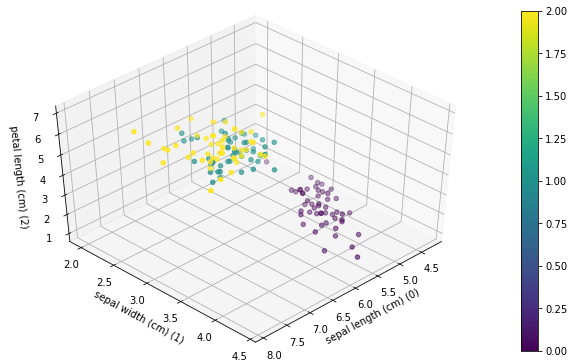

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

######################
## Figure = Makes a figure Obect
#####################
fig = plt.figure()

#######################
## Axes, basically, 1d,2d or 3d
#######################
ax = plt.axes(projection='3d')

########################
## Make Scatter Plot
########################
figiris = ax.scatter(iris.data[:,0],iris.data[:,1],iris.data[:,2],c=iris.target)
## Labels
ax.set_xlabel(iris.feature_names[0]+' (0)') # Setosa (Purple)
ax.set_ylabel(iris.feature_names[1]+' (1)') # Versicolor - Yellow
ax.set_zlabel(iris.feature_names[2]+' (2)') # Virginica - Green

# this adjusts the space around the plot so we can read the z label
plt.gcf().subplots_adjust(left=-0.5,bottom=-0.3)

plt.colorbar(figiris)
# Set the elevation and azimuth of the axes.
ax.view_init(45,45)

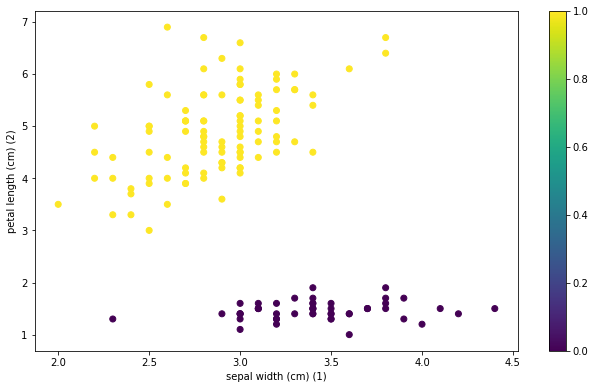

In [4]:
fig = plt.figure()
ax2 = plt.axes()
# 0 if setosia, else 1
figiris = ax2.scatter(iris.data[:,1],iris.data[:,2],c=np.where(iris.target == 0, 0,1))
ax2.set_xlabel(iris.feature_names[1]+' (1)')
ax2.set_ylabel(iris.feature_names[2]+' (2)')

# this adjusts the space around the plot so we can read the z label
plt.gcf().subplots_adjust(left=-0.5,bottom=-0.3)

plt.colorbar(figiris)
ax.view_init(45,45)

Sure enough it works. Let us train a perceptron with this data. Our training data are features 1 and 2, label is 1 if setosia, -1 else. A perceptron is a neural network with 1 layer, 1 node, linear activation function, and the ramp loss we discussed in class. Its inputs are weight two vectors (features 1 and 2). 

We could implement the perceptron algorithm as a loop of course. But we have a better way: to do this in keras. keras allows us to build a wide variety of networks either by simply building them layer by layer (Sequential) or as arbitrary graphs (we will worry about this later).

With the perceptron, 
1. The topology is trivial---just a single layer with one neuron
2. The input here has dimension 2 (feature 1 and 2)

Let us first put that into keras. keras also wants to know what activation function to use. We initially used the sign activation function, but doing so yielded a loss terrain with plateaus at different heights. It is difficult to figure out which direction to move here, so we shifted to the ramp loss instead. To compute the ramp loss, we just ask the neuron to output the entire dot product (z \dot w)---so essentially, the activation leaves the dot product unchanged. The way to do that is to use the linear activation function.


### More information
The sequential API allows you to create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

Alternatively, the functional API allows you to create models that have a lot more flexibility as you can easily define models where layers connect to more than just the previous and next layers. In fact, you can connect layers to (literally) any other layer. As a result, creating complex networks such as siamese networks and residual networks become possible.

In [5]:
model = Sequential([
    Dense(1, input_shape=(2,)),
    Activation('linear'),
])

### More info
#### Stochastic
Stochastic gradient descent is an iterative method for optimizing an objective function with suitable smoothness properties. 

#### Ramp
The ramp loss is a robust but non-convex loss for classification. Compared with other non-convex losses, a local minimum of the ramp loss can be effectively found. The effectiveness of local search comes from the piecewise linearity of the ramp loss. 

Not Useful Function ( Use Hinge Loss)

#### Tensorflow
Build for speed not convienience.

Need to make to float.

Loss functions must used Tensorflow and take 2 parameters. y_true = correct label; y_pred is the output of the neuron.

#### Perceptron
The Perceptron algorithm is the simplest type of artificial neural network.

It is a model of a single neuron that can be used for two-class classification problems and provides the foundation for later developing much larger networks.

- Name of Algorithm (SGD for Stochastic Gradient Descent)
- Loss functions

Ok, now on to the training algorithm. Recall that we use
1. stochastic gradient descent on the 
2. the ramp loss function

keras has a lot of useful loss functions built in, but the ramp loss is not one of them (though the hinge loss is). We will just write the function out here. Unfortunately, here there is a catch---we cannot use the extensive numpy libraries (though it is ok to pass numpy arrays here). Instead we have to use the tensorflow functions, which can sometimes be a little clumsy and eschews lot of automatic type conversions (because it is built for speed, not convenience always). That is why we explicity convert the label to a float below (else we could not multiply in the last line), and note that we write max (0.0, ...) not max (0, ...). This is to indicate that the comparison is a float comparison. If you do not do these things, TensorFlow will complain. 

loss functions we define *must* be tensorflow functions, and *always* take in two arguments (y_true and y_pred). y_true is the correct label of the example while y_pred is the output of the neuron (in our case, z\dot w, since we used linear activation). 

Finally perceptron training algorithm was vanilla stochastic gradient descent with learning parameter 1. We first pass the name of the algorithm (sgd for stochastic gradient descent, which is built into keras), the loss and what we are interested in achieving on test data (accuracy of classification---categorical accuracy in other words). 

### More info

### SGD
keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)

Stochastic gradient descent optimizer.

Includes support for momentum, learning rate decay, and Nesterov momentum.

Arguments

- learning_rate: float >= 0. Learning rate.
- momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
- nesterov: boolean. Whether to apply Nesterov momentum.

### model.compile
In the functional API, given some input tensor(s) and output tensor(s), you can instantiate a Model via:

from keras.models import Model
from keras.layers import Input, Dense

a = Input(shape=(32,))
b = Dense(32)(a)
model = Model(inputs=a, outputs=b)

Links: for arguments list https://keras.io/models/model/

### Callbacks
In Keras, Callback is a python class meant to be subclassed to provide specific functionality, with a set of methods called at various stages of training (including batch/epoch start and ends), testing, and predicting. Callbacks are useful to get a view on internal states and statistics of the model during training

In [6]:
from keras.optimizers import SGD


def perceptron_loss(y_true,y_pred):
    tf.cast(y_true, tf.float32)
    return(tf.maximum(0.0,-(y_true)*y_pred))

opt = SGD(lr=1)

model.compile(optimizer=opt, loss=perceptron_loss, metrics=['categorical_accuracy'])

We set the learning rate to 1. But in the future, we may want to tweak inside the optimizer beast. We look into this via what is called "callbacks". We can return arbitrary schedules (starting off with large learning rate, decreasing the step size as we go along, etc). But our algorithm is trivial---the rate is always 1.


In [7]:
from keras.callbacks import LearningRateScheduler

#################
## Learning rate tp 1
#################
def schedule(epoch_index,lrate):
    return(1.0)

keras.callbacks.callbacks.LearningRateScheduler(schedule, verbose=0)


Now, we prepare the training data by extracting columns 1 and 2 from the data. We want to separate out setosa (original label 0) from the other two classes, so we assign label 1 to setosas (original label 0) and -1 to the other two classes (original labels 1 and 2). 

In [8]:
training = iris.data[:,[1,2]]
labels = np.where(iris.target == 0, 1,-1)
print(labels)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]


Now we just get keras to train our model, and get the output at the end of the training into w

In [9]:
from keras.callbacks import LambdaCallback
import keras.backend as K

def tfprint(tensor):
    with tf.Session() as sess:
        arr = tensor.eval()
    print(arr)
    
print_weights = LambdaCallback(on_batch_begin=lambda batch, logs: print('\n w',batch,': \n',model.layers[0].get_weights()))
print_examples = LambdaCallback(on_batch_end = lambda batch, logs: print('\n z', batch,': \n', training[batch,:]))

print(model.layers[0].get_weights())

model.layers[0].set_weights([np.array([[0.01],[0.01]]),np.array([0.0])])

model.fit(training, labels, epochs=1, batch_size=1, callbacks = [print_weights,print_examples])

w = model.layers[0].get_weights()

[array([[-0.47328615],
       [ 0.4773866 ]], dtype=float32), array([0.], dtype=float32)]
Epoch 1/1

 w 0 : 
 [array([[0.01],
       [0.01]], dtype=float32), array([0.], dtype=float32)]
  1/150 [..............................] - ETA: 1:29 - loss: 0.0720 - categorical_accuracy: 1.0000
 z 0 : 
 [3.5 1.4]

 w 1 : 
 [array([[-2.99     ],
       [-4.1899996]], dtype=float32), array([-1.], dtype=float32)]

 z 1 : 
 [3.  1.4]

 w 2 : 
 [array([[ 0.71000004],
       [-2.6899996 ]], dtype=float32), array([0.], dtype=float32)]

 z 2 : 
 [3.2 1.3]

 w 3 : 
 [array([[ 3.81     ],
       [-1.1899996]], dtype=float32), array([1.], dtype=float32)]

 z 3 : 
 [3.1 1.5]

 w 4 : 
 [array([[ 0.90999985],
       [-5.3899994 ]], dtype=float32), array([0.], dtype=float32)]

 z 4 : 
 [3.6 1.4]

 w 5 : 
 [array([[ 3.9099998],
       [-4.089999 ]], dtype=float32), array([1.], dtype=float32)]

 z 5 : 
 [3.9 1.7]

 w 6 : 
 [array([[ 3.9099998],
       [-4.089999 ]], dtype=float32), array([1.], dtype=float32)]

 z


 w 70 : 
 [array([[ 3.9099998],
       [-4.089999 ]], dtype=float32), array([1.], dtype=float32)]
 71/150 [=============>................] - ETA: 1s - loss: 0.4448 - categorical_accuracy: 1.0000
 z 70 : 
 [3.2 4.8]

 w 71 : 
 [array([[ 3.9099998],
       [-4.089999 ]], dtype=float32), array([1.], dtype=float32)]

 z 71 : 
 [2.8 4. ]

 w 72 : 
 [array([[ 3.9099998],
       [-4.089999 ]], dtype=float32), array([1.], dtype=float32)]

 z 72 : 
 [2.5 4.9]

 w 73 : 
 [array([[ 3.9099998],
       [-4.089999 ]], dtype=float32), array([1.], dtype=float32)]

 z 73 : 
 [2.8 4.7]

 w 74 : 
 [array([[ 3.9099998],
       [-4.089999 ]], dtype=float32), array([1.], dtype=float32)]

 z 74 : 
 [2.9 4.3]

 w 75 : 
 [array([[ 3.9099998],
       [-4.089999 ]], dtype=float32), array([1.], dtype=float32)]

 z 75 : 
 [3.  4.4]

 w 76 : 
 [array([[ 3.9099998],
       [-4.089999 ]], dtype=float32), array([1.], dtype=float32)]

 z 76 : 
 [2.8 4.8]

 w 77 : 
 [array([[ 3.9099998],
       [-4.089999 ]], dtype=flo

Let us plot the separating line. The line is w0 x + w1 y + b=0, or y = -(b+w0 x)/w1

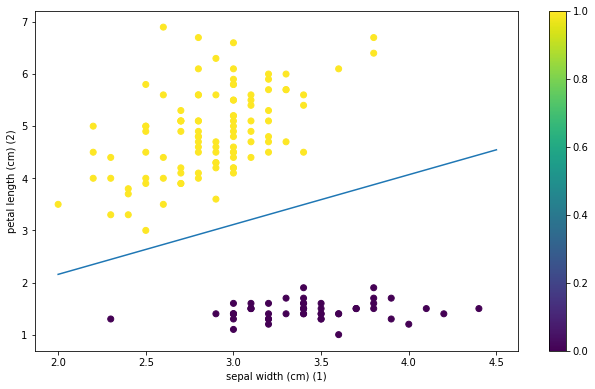

In [10]:
fig = plt.figure()
ax2 = plt.axes()
figiris = ax2.scatter(iris.data[:,1],iris.data[:,2],c=np.where(iris.target == 0, 0,1))
ax2.set_xlabel(iris.feature_names[1]+' (1)')
ax2.set_ylabel(iris.feature_names[2]+' (2)')
x = np.linspace(2,4.5,100)
plt.plot(x, -(w[1][0]+w[0][0,0]*x)/w[0][1,0])
# this adjusts the space around the plot so we can read the z label
plt.gcf().subplots_adjust(left=-0.5,bottom=-0.3)

plt.colorbar(figiris)
ax.view_init(45,45)

It worked as we expected it to! We want a little more transparency of course. Let us also retrieve the input and weights at the beginning of every example.

In [11]:
from keras.callbacks import LambdaCallback
import keras.backend as K

def tfprint(tensor):
    with tf.Session() as sess:
        arr = tensor.eval()
    print(arr)
    
print_weights = LambdaCallback(on_batch_begin=lambda batch, logs: print('\n w',batch,': \n',model.layers[0].get_weights()[0],'\n z:'))
print_examples = LambdaCallback(on_batch_end = lambda batch, logs: print(training[batch,:]))

model.compile(optimizer='sgd', loss=perceptron_loss, metrics=['categorical_accuracy'])


In [12]:
dir(model.layers[0])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_built',
 '_get_existing_metric',
 '_get_node_attribute_at_index',
 '_inbound_nodes',
 '_initial_weights',
 '_losses',
 '_metrics',
 '_node_key',
 '_non_trainable_weights',
 '_outbound_nodes',
 '_per_input_losses',
 '_per_input_updates',
 '_trainable_weights',
 '_updates',
 'activation',
 'activity_regularizer',
 'add_loss',
 'add_metric',
 'add_update',
 'add_weight',
 'assert_input_compatibility',
 'batch_input_shape',
 'bias',
 'bias_constraint',
 'bias_initializer',
 'bias_regularizer',
 'build',
 'built',
 'call',
 'compute_mask',
 'compute_output_shape',
 'count_params',
 'dtype',